In [1]:
import requests
import json
import pandas as pd

In [2]:
service_url = r"https://apps.deq.virginia.gov/arcgis/rest/services/public/EDMA/MapServer/175/query"
query = format = "pjson"

def query_service(url, where_clause="1=1", out_fields="*", return_geometry=False, max_record_count=30000):

    params = {
        "where": where_clause,
        "outFields": out_fields,
        "returnGeometry": str(return_geometry).lower(),
        "f": "json",
        "resultOffset": 0,
        "resultRecordCount": max_record_count
    }

    all_features = []
    while True:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an error for bad status codes
        data = response.json()

        # Extract features
        features = data.get("features", [])
        all_features.extend(features)

        # Check if there are more records to fetch
        if len(features) < max_record_count:
            break  # No more records
        else:
            # Update the offset for the next batch
            params["resultOffset"] += max_record_count

    return all_features


In [3]:
#save query json in chunks to list 
batch_start = 1
batch_end = 1000
data = []

while batch_end < 25000:
    data.append(query_service(service_url, where_clause = f'OBJECTID between {batch_start} and {batch_end}'))
    print(f"{batch_start}-{batch_end}: row count = {len(data)}")
    batch_start+=1000
    batch_end+=1000
    # with open("deq_prep_data.json", "w") as json_file:
    #     json.dump(data, json_file)

1-1000: row count = 1
1001-2000: row count = 2
2001-3000: row count = 3
3001-4000: row count = 4
4001-5000: row count = 5
5001-6000: row count = 6
6001-7000: row count = 7
7001-8000: row count = 8
8001-9000: row count = 9
9001-10000: row count = 10
10001-11000: row count = 11
11001-12000: row count = 12
12001-13000: row count = 13
13001-14000: row count = 14
14001-15000: row count = 15
15001-16000: row count = 16
16001-17000: row count = 17
17001-18000: row count = 18
18001-19000: row count = 19
19001-20000: row count = 20
20001-21000: row count = 21
21001-22000: row count = 22
22001-23000: row count = 23
23001-24000: row count = 24


In [4]:
# Combine lists of json to one list
combined_data = data[0].copy() 
i=1
for i in range(len(data)):
    combined_data.extend(data[i])
    i+=1

In [5]:
range(len(combined_data))
print(combined_data[24999])

{'attributes': {'OBJECTID': 24000, 'REFERENCE_POINT': 'FC', 'PRP_REPORT_ID': '295809', 'PRP_REPORT_RECEIVED_DATE_TIME': 1594365720000, 'PRP_INCIDENT_DATE_TIME': 1594215240000, 'PRP_INCIDENT_CLOSURE_DATE': 1603360122000, 'RSC_STATUS_DESCRIPTION': 'Closed', 'SRC_STATUS_REASON_DESC': 'Pollution report being managed by a media-specific program.', 'PRP_SITE_NAME': 'Alleged Improper Waste Disposal - Walgreens 05216', 'PRP_SITE_ADDRESS1': '4049 Brambleton Avenue', 'PRP_SITE_ADDRESS2': None, 'PRP_SITE_CITY': 'Roanoke', 'PRP_SITE_STATE': 'VA', 'PRP_SITE_ZIP_CODE': '24018', 'PRP_ASSIGNED_STAFF_PROGRAM_ID': 202, 'Data_Disclaimer': None}}


In [6]:
#format json for dataframe
df = pd.json_normalize(combined_data)
print(df.shape)
print(df.head())

(25000, 16)
   attributes.OBJECTID attributes.REFERENCE_POINT attributes.PRP_REPORT_ID  \
0                    1                         FC                   295110   
1                    2                         PG                   295126   
2                    3                         PG                   295154   
3                    4                         PG                   295161   
4                    5                         PG                   295169   

   attributes.PRP_REPORT_RECEIVED_DATE_TIME  \
0                              1.589990e+12   
1                              1.590062e+12   
2                              1.590154e+12   
3                              1.590165e+12   
4                              1.590345e+12   

   attributes.PRP_INCIDENT_DATE_TIME  attributes.PRP_INCIDENT_CLOSURE_DATE  \
0                       1.589974e+12                          1.591014e+12   
1                       1.590054e+12                          1.661866e+12   
2 

In [7]:
#clean column names from dataframe
column_names = df.columns.tolist()
column_names = [item.replace('attributes.','').lower() for item in column_names]
column_names = [item.replace('prp_','') for item in column_names]
print(column_names)

['objectid', 'reference_point', 'report_id', 'report_received_date_time', 'incident_date_time', 'incident_closure_date', 'rsc_status_description', 'src_status_reason_desc', 'site_name', 'site_address1', 'site_address2', 'site_city', 'site_state', 'site_zip_code', 'assigned_staff_program_id', 'data_disclaimer']


In [8]:
df.columns = column_names
print(df.columns)

Index(['objectid', 'reference_point', 'report_id', 'report_received_date_time',
       'incident_date_time', 'incident_closure_date', 'rsc_status_description',
       'src_status_reason_desc', 'site_name', 'site_address1', 'site_address2',
       'site_city', 'site_state', 'site_zip_code', 'assigned_staff_program_id',
       'data_disclaimer'],
      dtype='object')


In [9]:
# extract just the descriptions from site_name column for further phrase frequency analysis
descriptions = df['site_name'].tolist()
text = ", ".join(str(string) for string in descriptions)
print(text)

SSO - Town of Christiansburg, SSO - City of Martinsville, City of VB, Indian River - Hydrolic Fluid, MVP - stream turbidity, Propane Release - Private Residence, Overflow - Eastman Performance Films LLC - Fieldale, Diesel Spill - The Anderson Company, SSO - WVWA, SSO/UPD 18 JUN 2020 (Chase City WWTP INfluent PS) est 3000 gals, Duplicate of IR 295688, Tire complaint - Appomattox Farm & Home, Used Oil Spill (8 gals) - MCB Quantico, Colonna's Shipyard AFFF, SSO/UPD 19 JUN 2020 7087 Mill Valley Road, Hanover Co. (est. 3000 gals), Poquoson - new construction sediment control, SSO - City of Salem, SSO - private residence, Chesapeake - Wetland debris, SSO - Bluefield Sanitary Board - Bluefield Westside WWTP - Bluestone Diversion Station, Diesel Spill - Unknown RP, Skin Rash After Paddling Little Walker Creek - Giles County, SSO - Town of Clifton Forge, Carvin Cove Lift station, Livestock in Water - Lake Anna, VDEM-2020-06-06-589 Lancaster Sunken Vessel and Vessel Fire, Basf Property - liquid 

In [10]:
import nltk
from collections import Counter
from nltk.util import ngrams
import string

nltk.download('punkt_tab')

ignore_text = ['city', 'county', 'virginia', 'town', 'norfolk', 'bristol', 'portsmouth', 'newport','news']

def preprocess_text(text):
    # Lowercase the text
    text = str(text).lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove location phrases
    for ignore in ignore_text:
        text = text.replace(ignore,'')
    return text

def extract_frequent_ngrams(text_list, ngram_range=(2,3), top_k=100):
    #Extracts the top_k most frequent n-grams from the list of strings.
    all_ngrams = []

    for text in text_list:
        preprocessed_text = preprocess_text(text)
        tokens = nltk.word_tokenize(preprocessed_text)
        for n in range(ngram_range[0], ngram_range[1]+1):
            n_grams = ngrams(tokens, n)
            all_ngrams.extend(n_grams)

    ngram_counts = Counter(all_ngrams)
    return ngram_counts.most_common(top_k)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akenv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [11]:
ngrams = extract_frequent_ngrams(descriptions)

In [12]:
top_ngrams = ngrams[0:16]
keyword_df = pd.DataFrame(top_ngrams, columns = ['Phrase', 'Frequency'])
print(keyword_df)

                  Phrase  Frequency
0              (sso, of)       1583
1            (sso, wvwa)        671
2          (unknown, rp)        536
3       (landfill, odor)        514
4      (diesel, release)        425
5          (tta, diesel)        412
6           (oil, spill)        407
7        (pump, station)        391
8        (diesel, spill)        360
9       (hydraulic, oil)        337
10        (oil, release)        311
11    (dominion, energy)        255
12  (private, residence)        252
13            (us, navy)        250
14          (fish, kill)        241
15      (unknown, sheen)        220


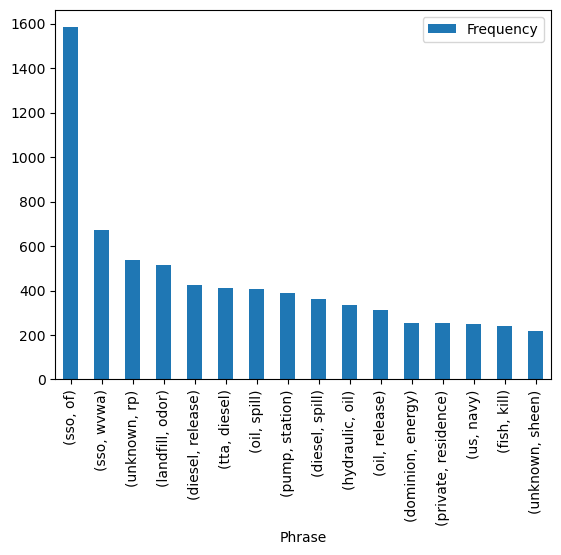

In [13]:
import matplotlib.pyplot as plt

keyword_df.plot.bar('Phrase','Frequency')
plt.show()

In [14]:
#convert to list to dict for wordcloud lib
keys = [" ".join(ngram[0]) for ngram in ngrams][0:100]
values = [freq[1] for freq in ngrams][0:100]

keyword_dict = dict(zip(keys, values))
keyword_dict = keyword_dict
print(keyword_dict)

{'sso of': 1583, 'sso wvwa': 671, 'unknown rp': 536, 'landfill odor': 514, 'diesel release': 425, 'tta diesel': 412, 'oil spill': 407, 'pump station': 391, 'diesel spill': 360, 'hydraulic oil': 337, 'oil release': 311, 'dominion energy': 255, 'private residence': 252, 'us navy': 250, 'fish kill': 241, 'unknown sheen': 220, 'odor concern': 219, 'sso hcpsa': 205, 'hydraulic fluid': 203, 'illicit discharge': 195, 'water discharge': 190, 'saddle tank': 182, 'mineral oil': 173, 'bypass of': 170, 'tta diesel release': 168, 'tire pile': 168, 'concern boxley': 166, 'odor concern boxley': 162, 'of christiansburg': 159, 'of lynchburg': 153, 'waste tire': 153, 'open burning': 150, 'naval station': 150, 'gallons of': 149, 'of salem': 147, 'motor oil': 147, 'waste tire pile': 145, 'sso of salem': 142, 'sso of christiansburg': 141, 'tank release': 139, 'sso brwa': 137, 'boxley materials': 134, 'sso of lynchburg': 133, 'concern boxley materials': 131, 'gasoline spill': 129, 'navy nsn': 127, 'us navy 

In [15]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


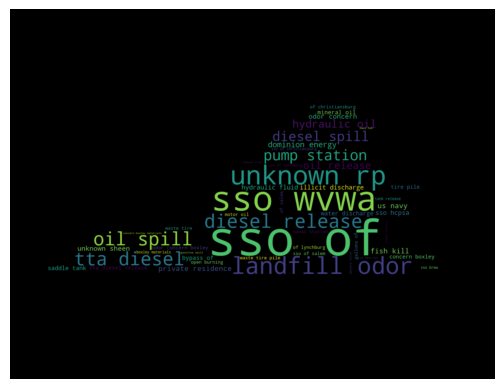

In [16]:
from PIL import Image
import numpy as np
from os import path
from wordcloud import WordCloud

va_mask = np.array(Image.open("va_mask.png"))
wc = WordCloud(background_color="black", max_words=50, mask=va_mask, contour_width=3)

# generate word cloud
wc.generate_from_frequencies(keyword_dict)

# store to file
wc.to_file('wordcloud.png')

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()